In [1]:
import pandas as pd
import numpy as np
import math
from sklearn import datasets, linear_model, metrics, feature_extraction, model_selection
from matplotlib import pyplot as plt
import seaborn as sns
import math
plt.style.use("ggplot")
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 15

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go

init_notebook_mode(connected=True)

In [3]:
def daysInMonth(x):
    return 28 + ((x + math.floor(x / 8)) % 2 + (2 % x) + (2 * math.floor(1/x)))


daysFromYearStart = [0]
def getDaysFromYearStart(month, day):
    while len(daysFromYearStart) <= month:
        l = len(daysFromYearStart)
        daysFromYearStart.append(daysFromYearStart[l - 1] + daysInMonth(l))
    return daysFromYearStart[month] - (daysInMonth(month) - day)


def dropRare(frame, clsName, minCount):
    counts = frame[clsName].value_counts()
    return frame.drop(df[df[clsName].isin(counts[counts < minCount].index)].index)


def reclassMeanOpt(frame, targetSrc, clsName, meanName, drop=False):
    if meanName in frame.columns:
        if drop:
            print("%s found in dataframe, drop=True, dropping" % meanName)
            frame = frame.drop(meanName, axis=1)
        else:
            print("%s found in dataframe, drop=False, skipping" % meanName)
            return frame
    mean_frame = targetSrc[[clsName, 'target']].groupby(clsName).agg('mean').reset_index()
    mean_frame.rename(columns={'target':meanName}, inplace = True)
    return pd.merge(frame, mean_frame, on=clsName)
    
    
def reclassMean(frame, targetSrc, clsName, meanName, targetExtractor = lambda f, c: f[[c, 'target']].groupby(c).mean(), excluders=[]):
    def getMean(c): 
        if c not in meanInfo or c in excluders:
            meanInfo[c] = meanInfo.mean()
        return meanInfo[c]
    meanInfo = targetExtractor(targetSrc, clsName)
    frame[meanName] = frame[clsName].map(lambda c: getMean(c))
        
    
def split_time(time):
    time = str(int(time))
    time = ('0' * (4 - len(time))) + time
    hours = int(time[0:2])
    minutes = int(time[2:4])
    return {"H": hours, "M": minutes}


def reclass_time(frame, orig, hours, minutes): 
    t = frame[orig].map(split_time)
    frame[hours] = t.map(lambda t: t["H"])
    frame[minutes] = t.map(lambda t: t["M"])

In [4]:
df = pd.read_csv("train_dataset.csv")
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,Dest,Distance,TaxiIn,TaxiOut,target
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,DFW,190,15.0,13.0,1
1,1,1,2,1411.0,1521.0,NW,1631,N363NB,37.0,TVC,DTW,207,9.0,24.0,1
2,1,1,2,859.0,1112.0,MQ,4645,N700LE,103.0,BDL,RDU,532,3.0,27.0,0
3,1,1,2,1835.0,2159.0,MQ,4838,N704PG,130.0,XNA,LGA,1147,6.0,8.0,1
4,1,1,2,1305.0,1924.0,US,185,N655AW,229.0,PHX,FLL,1972,9.0,21.0,1


In [5]:
df = df.dropna()
df = df.drop(df[df["AirTime"] == 0].index)

In [6]:
df = dropRare(df, "FlightNum", 20)
df = dropRare(df, "Dest", 5)
df = dropRare(df, "Origin", 5)

In [7]:
df["DayOfYear"] = df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)

In [8]:
df["AirTimeFrame"] = df["AirTime"].map(lambda x: math.log((x // 30) + 1, 10))

In [9]:
reclass_time(df, "DepTime", "DepHour", "DepMinute")
df["DepTotalMinutes"] = df["DepHour"] * 60 + df["DepMinute"]
df["DepTimeFrame"] = df["DepTotalMinutes"] // 15

In [10]:
df["HourOfYear"] = df["DayOfYear"] * 24 - (24 - df["DepHour"])

In [11]:
df.columns

Index(['Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'ArrTime',
       'UniqueCarrier', 'FlightNum', 'TailNum', 'AirTime', 'Origin', 'Dest',
       'Distance', 'TaxiIn', 'TaxiOut', 'target', 'DayOfYear', 'AirTimeFrame',
       'DepHour', 'DepMinute', 'DepTotalMinutes', 'DepTimeFrame',
       'HourOfYear'],
      dtype='object')

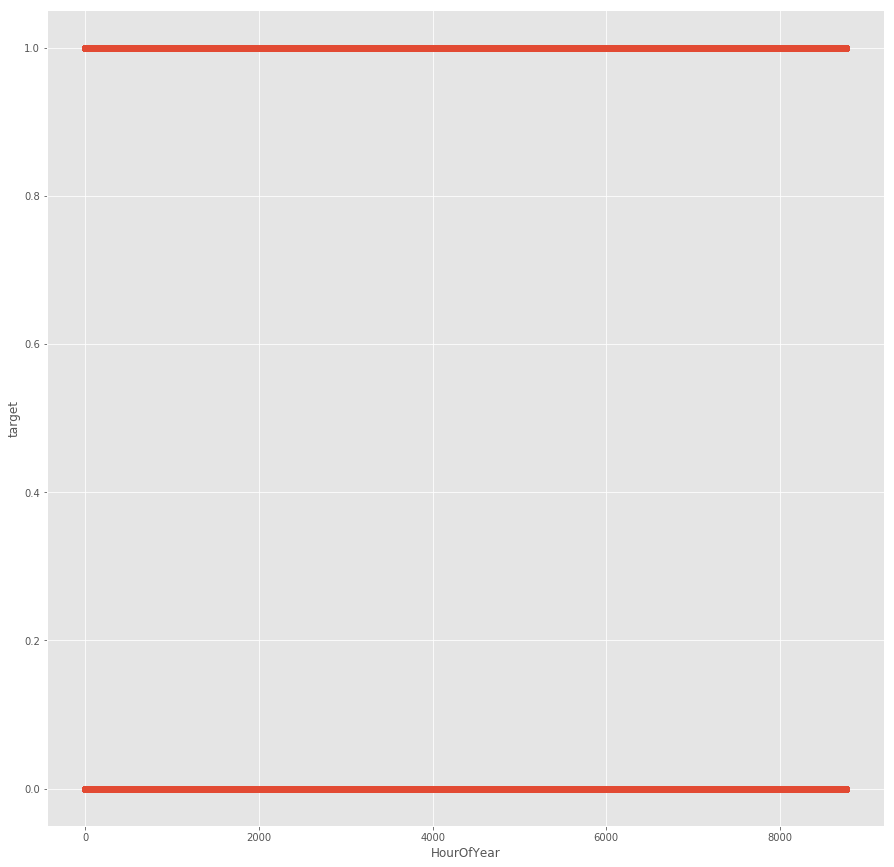

In [12]:
sns.regplot(df["HourOfYear"], df["target"], fit_reg=False)

In [12]:
df = reclassMeanOpt(df, df, "UniqueCarrier", "CarrierChance")
df = reclassMeanOpt(df, df, "Dest", "DestChance")
df = reclassMeanOpt(df, df, "Origin", "OriginChance")
df = reclassMeanOpt(df, df, "FlightNum", "FlightChance")
df = reclassMeanOpt(df, df, "HourOfYear", "HOYChance")
df = reclassMeanOpt(df, df, "TailNum", "PlaneChance")
df = reclassMeanOpt(df, df, "AirTimeFrame", "AirFrameChance", drop=True)
df = reclassMeanOpt(df, df, "DepTimeFrame", "DepFrameChance", drop=True)
df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,DepTimeFrame,HourOfYear,CarrierChance,DestChance,OriginChance,HOYChance,FlightChance,PlaneChance,AirFrameChance,DepFrameChance
0,1,1,2,1007.0,1109.0,AA,511,N404AA,34.0,AUS,...,40,10,0.340092,0.271783,0.252787,0.337391,0.284528,0.314410,0.276389,0.241725
1,5,19,1,1003.0,1107.0,AA,1599,N404AA,46.0,DFW,...,40,3322,0.340092,0.256705,0.364943,0.236422,0.336493,0.314410,0.276389,0.241725
2,7,18,5,1010.0,1117.0,AA,1352,N404AA,36.0,DFW,...,40,4762,0.340092,0.351399,0.364943,0.201201,0.260949,0.314410,0.276389,0.241725
3,2,6,3,1014.0,1109.0,AA,728,N404AA,38.0,SAT,...,40,874,0.340092,0.271783,0.260605,0.393762,0.289522,0.314410,0.276389,0.241725
4,6,28,6,1004.0,1116.0,US,182,N807AW,47.0,PHX,...,40,4282,0.234534,0.303304,0.299572,0.322091,0.292072,0.187404,0.276389,0.241725


In [44]:
used_cols = ["AirFrameChance",
             "DepFrameChance",
             "FlightChance",
             #"DOWChance",
             #"MonthChance",
             #"DOYChance",
             "HOYChance",
             "OriginChance",
             "DestChance",
             "CarrierChance",
             "TaxiIn",
             "TaxiOut"]
clf_df = df[used_cols + ["target"]]

In [48]:
clf_df.head()

,AirFrameChance,DepFrameChance,FlightChance,HOYChance,OriginChance,DestChance,CarrierChance,TaxiIn,TaxiOut,target
0,0.276389,0.241725,0.284528,0.337391,0.252787,0.271783,0.340092,15.0,13.0,1
1,0.276389,0.241725,0.218810,0.337391,0.364943,0.302727,0.340092,5.0,30.0,0
2,0.276389,0.241725,0.518447,0.337391,0.241231,0.302751,0.338490,3.0,9.0,0
3,0.276389,0.241725,0.336493,0.337391,0.364943,0.256705,0.340092,7.0,9.0,1
4,0.276389,0.241725,0.260949,0.337391,0.364943,0.351399,0.340092,5.0,12.0,0


In [49]:
from sklearn.utils import shuffle
shuffled_df = shuffle(clf_df)

In [50]:
labels = shuffled_df["target"]
clf_train, clf_test, label_train, label_test = model_selection.train_test_split(shuffled_df.drop("target", axis=1), labels, test_size = 0.3)

In [51]:
clf = linear_model.LogisticRegression()
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5]}
opt = model_selection.GridSearchCV(clf, param_grid, cv=3, n_jobs=4, return_train_score=True)

In [52]:
opt.fit(clf_train, label_train)
for i, c in enumerate(opt.best_estimator_.coef_[0]):
    print("%s: %f" % (clf_df.columns[i], c))

AirFrameChance: 2.472709
DepFrameChance: 0.777115
FlightChance: 2.341174
HOYChance: 4.532877
OriginChance: 2.117318
DestChance: 2.318180
CarrierChance: 3.914187
TaxiIn: -0.000486
TaxiOut: 0.012268


In [53]:
predpr = opt.predict_proba(clf_test)

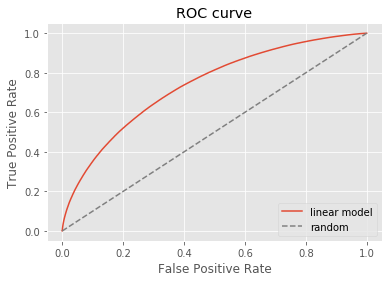

0.736369174001


In [54]:
fpr, tpr, _ = metrics.roc_curve(label_test, predpr[:,1])
plt.plot(fpr, tpr, label = 'linear model')
plt.plot([0, 1], [0, 1], '--', color = 'grey', label = 'random')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc = "lower right");
plt.show()
print(metrics.roc_auc_score(label_test, predpr[:,1]))

In [80]:
test_df = pd.read_csv("test_dataset.csv")

In [81]:
test_df.shape

(3504864, 15)

In [92]:
test_df.head()

,Month,DayofMonth,DayOfWeek,DepTime,ArrTime,UniqueCarrier,FlightNum,TailNum,AirTime,Origin,...,AirTimeFrame,DepHour,DepMinute,DepTotalMinutes,DepTimeFrame,DayOfYear,HourOfYear,CarrierChance,DestChance,OriginChance
0,1,1,2,1851.0,2029.0,UA,735,N386UA,113.0,ALB,...,0.602060,18,51,1131,75,1,18,0.336518,0.335250,0.246846
1,1,1,2,1847.0,2029.0,CO,809,N15710,191.0,IAH,...,0.845098,18,47,1127,75,1,18,0.362654,0.273343,0.336993
2,1,1,2,1522.0,1622.0,MQ,4298,N676AE,28.0,ORD,...,0.000000,15,22,922,61,1,15,0.313444,0.301629,0.391043
3,1,1,2,2013.0,2303.0,NW,876,N780NC,90.0,MSP,...,0.602060,20,13,1213,80,1,20,0.240546,0.336796,0.263729
4,1,1,2,1649.0,1727.0,FL,547,N920AT,83.0,ATL,...,0.477121,16,49,1009,67,1,16,0.289026,0.353794,0.339618


In [83]:
test_df = test_df.fillna(0)

In [84]:
test_df["AirTimeFrame"] = test_df["AirTime"].map(lambda x: math.log10(x // 30 + 1))

In [85]:
reclass_time(test_df, "DepTime", "DepHour", "DepMinute")
test_df["DepTotalMinutes"] = test_df["DepHour"] * 60 + test_df["DepMinute"]
test_df["DepTimeFrame"] = test_df["DepTotalMinutes"] // 15

In [87]:
test_df["DayOfYear"] = test_df.apply(lambda x: getDaysFromYearStart(x["Month"], x["DayofMonth"]), axis=1)
test_df["HourOfYear"] = test_df["DayOfYear"] * 24 - (24 - test_df["DepHour"])

In [88]:
def remean(name, meanName):
    mean_info = df[[name, "target"]].groupby(name)["target"].mean()
    def _getMean(x):
        if x not in mean_info:
            mean_info[x] = mean_info.mean()
        return mean_info[x]
    test_df[meanName] = test_df[name].map(_getMean)

In [93]:
remean("UniqueCarrier", "CarrierChance")
remean("Dest", "DestChance")
remean("Origin", "OriginChance")

remean("HourOfYear", "HOYChance")

In [94]:
remean("FlightNum", "FlightChance")

In [95]:
remean("AirTimeFrame", "AirFrameChance")
remean("DepTimeFrame", "DepFrameChance")

In [96]:
test_clf_df = test_df[used_cols]

In [97]:
test_clf_df.shape

(3504864, 9)

In [98]:
test_clf_df.head()

,AirFrameChance,DepFrameChance,FlightChance,HOYChance,OriginChance,DestChance,CarrierChance,TaxiIn,TaxiOut
0,0.393110,0.337727,0.289054,0.567568,0.246846,0.335250,0.336518,7.0,38.0
1,0.393110,0.337727,0.253774,0.567568,0.336993,0.273343,0.362654,7.0,24.0
2,0.231591,0.353605,0.341615,0.551601,0.391043,0.301629,0.313444,3.0,29.0
3,0.393110,0.472922,0.231183,0.679204,0.263729,0.336796,0.240546,6.0,14.0
4,0.289973,0.331897,0.390118,0.542673,0.339618,0.353794,0.289026,5.0,10.0


In [99]:
test_pred = opt.predict_proba(test_clf_df)

In [100]:
test_pred[:, 1]

array([ 0.70394802,  0.6816759 ,  0.63608066, ...,  0.35925643,
        0.44472745,  0.35345137])

In [101]:
test_pred_df = pd.DataFrame(test_pred[:, 1], columns=["Prediction1"])

In [102]:
test_pred_df.index.name = "Id"

In [103]:
test_pred_df.head()

,Prediction1
Id,
0,0.703948
1,0.681676
2,0.636081
3,0.670736
4,0.608587


In [104]:
test_pred_df.to_csv("sample_1.csv")